In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from  matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import seaborn as sn
import sys
import os
from pathlib import Path
from tqdm import tqdm
from timeit import default_timer as timer
from datetime import timedelta

import torch.nn as nn
from torch import Tensor
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from torchmetrics.classification import BinaryCalibrationError

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import calibration_curve

from scipy.stats import wasserstein_distance
from sklearn.metrics import roc_auc_score as roc_auc_score
from scipy.special import kl_div as kl_div
from sklearn.metrics import log_loss as log_loss

# import custom functions from src folder
module_path = str(Path.cwd() / "../../../src")

if module_path not in sys.path:
    sys.path.append(module_path)

from SequentialNet import SequentialNet
from machine_learning import *
from util import *


In [26]:
sn.set_palette("tab10")
sn.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [27]:
def word_to_int(df):
    # Red = 0, blue = 1
    df["class"] = 0
    df_copy = df.copy()
    mask = df_copy["color"] == "blue"
    df.loc[mask, "class"] = 1
    return df

def label_maker(values, num_classes):
    labels = np.zeros((len(values), num_classes))
    for i, value in enumerate(values):
        labels[i][value] = 1
    return torch.Tensor(labels).to(torch.int)

In [28]:
def predict_grid(model, x1_key, x2_key, device, nx:int = 100):
    x1_lim = 25
    x2_lim = 25
    x1 = np.linspace(-x1_lim, x1_lim, nx)
    x2 = np.linspace(-x2_lim, x2_lim, nx)
    xx1, xx2 = np.meshgrid(x1, x2)
    df = pd.DataFrame(columns = ["x1", "x2"], index = range(len(xx1.flatten())))
    df["x1"] = xx1.flatten()
    df["x2"] = xx2.flatten()
    df = cartesian_to_polar_df(df, "x1", "x2", "r_x", "a_x")

    X_gridtest = torch.Tensor(np.dstack((df[x1_key], df[x2_key]))).to(torch.float32)[0]
    Y_gridtest = torch.zeros(X_gridtest.shape)
    gridtest_dataset = torch.utils.data.TensorDataset(X_gridtest, Y_gridtest)

    truth, logits = predict_classifier(model, gridtest_dataset, 2, 100, device)
    preds = torch.argmax(logits, dim=-1).flatten()
    df["Prediction"] = preds
    df["Truth"] = truth
    #Get softmax score for blue
    df["Confidence"] = torch.softmax(logits, dim=-1)[:,1]
    return df

In [29]:
# Set up device
device = (
    "cuda:1"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device {torch.cuda.get_device_name(1)}")

Using cuda:1 device NVIDIA TITAN V


In [30]:
# Machine learning options
x1_key = "x1"
x2_key = "x2"
n_data = [250, 1000, 2000, 3000, 5000]
#n_data = [10000]
max_err_val = [0]*len(n_data)
for i in range(len(n_data)):
    if n_data[i] < 1000:
        max_err_val[i] = 0.5
    else:
        max_err_val[i] = 0.25
patience = 70
load_ensemble_values = True

#Data constants
R2 = 3
k_red = 7
k_blue = 3
R1_min = 6
scale = 1
vary_a1 = False
vary_R2 = False
p_red = 0.5
polar = True
tag = f'r2_{R2}_kr{k_red}_kb{k_blue}_r1min{R1_min}_s{scale}_vary_r2_{vary_R2}_vary_a1_{vary_a1}_pRed_{p_red}'

# Read files
train_n = 50000
trainfile = f"train_n_{train_n}_{tag}"
valfile = f"val_n_5000_{tag}"
testfile = f"test_n_10000_{tag}"
truthfile = f"analytical_solution_x1_x2_grid_{tag}_nr1MC_4000"
truthfile_test = "analytical_solution_test_n_10000_r2_3_kr7_kb3_r1min6_s1_vary_r2_False_vary_a1_False_pRed_0.5_nr1MC_8000"
gridfile = f"x1_x2_grid"

train_data = pd.read_csv(f"../data/{trainfile}.csv")
val_data = pd.read_csv(f"../data/{valfile}.csv")
test_data = pd.read_csv(f"../data/{testfile}.csv")
truth_data = pd.read_csv(f"../analytical/results/{truthfile}.csv")
truth_data = truth_data[truth_data["r_x"] > R1_min-R2] # Remove undefined area
truth_test_data = pd.read_csv(f"../analytical/results/{truthfile_test}.csv")
grid_data = pd.read_csv(f"../data/{gridfile}.csv")

#Correct analytical solution if class distribution is not equal
if p_red != 0.5:
    truth_data["P_red_and_x"] = truth_data["P_red_and_x"]*(p_red)/0.5
    truth_data["P_blue_and_x"] = truth_data["P_blue_and_x"]*(1-p_red)/0.5
    truth_data["P_x"] = truth_data["P_red_and_x"] + truth_data["P_blue_and_x"]
    truth_data["P_red_given_x"] = truth_data["P_red_and_x"]/truth_data["P_x"]
    truth_data["P_blue_given_x"] = truth_data["P_blue_and_x"]/truth_data["P_x"]

# Prepare data for pytorch
train_data = word_to_int(train_data)
val_data = word_to_int(val_data)
test_data = word_to_int(test_data)

X_train = torch.Tensor(np.dstack((train_data[x1_key], train_data[x2_key]))).to(torch.float32)[0]
Y_train = label_maker(train_data["class"], 2)

X_val = torch.Tensor(np.dstack((val_data[x1_key], val_data[x2_key]))).to(torch.float32)[0]
Y_val = label_maker(val_data["class"], 2)

X_test = torch.Tensor(np.dstack((test_data[x1_key], test_data[x2_key]))).to(torch.float32)[0]
Y_test = torch.zeros(X_test.shape)

In [31]:
# Create datasets for pytorch
train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, Y_val)
test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)

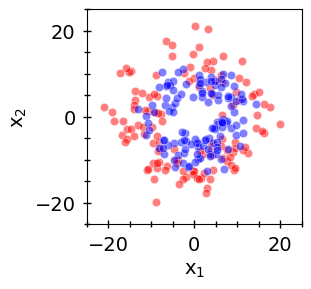

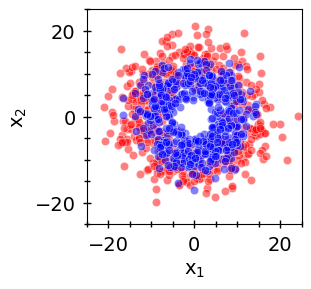

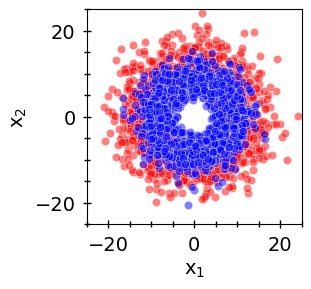

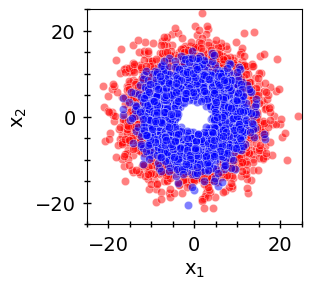

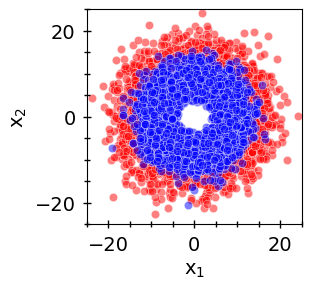

In [32]:
# Plot training data

for i in range(len(n_data)):
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (3, 3), layout="constrained")
    axs = plot_data(train_data[0:n_data[i]], ax, "")
    fig.savefig(f"../train_data_n_{n_data[i]}.pdf")

## Ensembling

In [33]:

def train_ensemble(n_ensemble, n_data):
    val_data_ensembles = pd.read_csv(f"../data/{valfile}.csv")
    test_data_ensembles = pd.read_csv(f"../data/{testfile}.csv")
    grid_ensembles = pd.DataFrame(columns = ["x1", "x2", "r_x", "a_x"], index = range(100*100))
    # Timer
    start = timer()
    print(f"Starting training of {n_ensemble} ensembles with {n_data} training points.")
    for i in range(n_ensemble):

        # Fresh validation dataframe
        val_data = pd.read_csv(f"../data/{valfile}.csv")
        val_data = word_to_int(val_data)

        # Create datasets
        train_dataset = torch.utils.data.TensorDataset(X_train[0:n_data], Y_train[0:n_data])

        # Create new model
        model = SequentialNet(L=1024, n_hidden=3, activation="relu", in_channels=2, out_channels=2).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        # Train model
        training_results = train_classifier(model, train_dataset, 
                                val_dataset, batchsize=2**9, epochs = 70, 
                                device = device, optimizer = optimizer, early_stopping=patience)
        
        # Predict on validation set
        truth_val, logits_val = predict_classifier(model, val_dataset, 2, 100, device)
        preds_val = torch.argmax(logits_val, dim=-1).flatten()
        val_data_ensembles[f"Prediction_{i}"] = preds_val
        val_data_ensembles["Truth"] = truth_val
        #Get softmax score for blue
        val_data_ensembles[f"Confidence_{i}"] = torch.softmax(logits_val, dim=-1)[:,1]

        # Predict on test set
        truth_test, logits_test = predict_classifier(model, test_dataset, 2, 100, device)
        preds_test = torch.argmax(logits_test, dim=-1).flatten()
        test_data_ensembles[f"Prediction_{i}"] = preds_test
        test_data_ensembles["Truth"] = truth_test
        #Get softmax score for blue
        test_data_ensembles[f"Confidence_{i}"] = torch.softmax(logits_test, dim=-1)[:,1]

        # Predict for grid
        grid_df = predict_grid(model, x1_key, x2_key, device)
        grid_ensembles[f"x1"] = grid_df["x1"]
        grid_ensembles[f"x2"] = grid_df["x2"]
        grid_ensembles[f"r_x"] = grid_df["r_x"]
        grid_ensembles[f"a_x"] = grid_df["a_x"]
        grid_ensembles[f"Confidence_{i}"] = grid_df["Confidence"]
    end = timer()
    print("Training time: ", timedelta(seconds=end-start))
    return val_data_ensembles, test_data_ensembles, grid_ensembles

n_ensemble = 10

if load_ensemble_values==False:
    for i in range(len(n_data)):
        logloss_min = 1
        for j in tqdm(range(20)):
            val_df, test_df, grid_df = train_ensemble(n_ensemble, n_data[i])
            val_df["Confidence_avg"] = val_df[[f"Confidence_{i}" for i in range(n_ensemble)]].mean(axis=1)
            val_df["Confidence_std"] = val_df[[f"Confidence_{i}" for i in range(n_ensemble)]].std(axis=1)
            val_df["Prediction_ensemble"] = 0
            mask = val_df["Confidence_avg"] > 0.5
            val_df.loc[mask, "Prediction_ensemble"] = 1

            ll = log_loss(val_df["class"], val_df["Confidence_avg"])
            preds = torch.Tensor(val_df["Confidence_avg"])
            target = torch.Tensor(val_df["class"])
            bce_l1 = BinaryCalibrationError(n_bins=15, norm='l1')
            ece = bce_l1(preds, target).item()
            print(f"n_train = {n_data[i]}, logloss={ll}, ECE= {ece}")

            if ll < logloss_min:
                print(f"New best values: n_train = {n_data[i]}, logloss={ll}, ECE= {ece}")
                logloss_min = ll

                val_data_ensembles = val_df
                test_data_ensembles = test_df
                grid_ensembles = grid_df

                test_data_ensembles["Confidence_avg"] = test_data_ensembles[[f"Confidence_{i}" for i in range(n_ensemble)]].mean(axis=1)
                test_data_ensembles["Confidence_std"] = test_data_ensembles[[f"Confidence_{i}" for i in range(n_ensemble)]].std(axis=1)
                test_data_ensembles["Prediction_ensemble"] = 0
                mask = test_data_ensembles["Confidence_avg"] > 0.5
                test_data_ensembles.loc[mask, "Prediction_ensemble"] = 1

                grid_ensembles["Confidence_avg"] = grid_ensembles[[f"Confidence_{i}" for i in range(n_ensemble)]].mean(axis=1)
                grid_ensembles["Confidence_std"] = grid_ensembles[[f"Confidence_{i}" for i in range(n_ensemble)]].std(axis=1)
        # Save best prediction
        if (not os.path.isdir(f"predictions/{trainfile}") ):
            os.mkdir(f"predictions/{trainfile}")
        val_data_ensembles.to_csv(f"predictions/{trainfile}/{valfile}_predicted_SequentialNet_{n_ensemble}ensembles_ndata-{n_data[i]}_POLAR.csv")
        test_data_ensembles.to_csv(f"predictions/{trainfile}/{testfile}_predicted_SequentialNet_{n_ensemble}ensembles_ndata-{n_data[i]}_POLAR.csv")
        grid_ensembles.to_csv(f"predictions/{trainfile}/grid_{tag}_predicted_SequentialNet_{n_ensemble}ensembles_ndata-{n_data[i]}_POLAR.csv")

    val_data_ensembles = [pd.read_csv(f"predictions/{trainfile}/{valfile}_predicted_SequentialNet_{n_ensemble}ensembles_ndata-{n_data[i]}_POLAR.csv") for i in range(len(n_data))]
    test_data_ensembles = [pd.read_csv(f"predictions/{trainfile}/{testfile}_predicted_SequentialNet_{n_ensemble}ensembles_ndata-{n_data[i]}_POLAR.csv") for i in range(len(n_data))]
    grid_ensembles = [pd.read_csv(f"predictions/{trainfile}/grid_{tag}_predicted_SequentialNet_{n_ensemble}ensembles_ndata-{n_data[i]}_POLAR.csv") for i in range(len(n_data))]

else:
    val_data_ensembles = [pd.read_csv(f"predictions/{trainfile}/{valfile}_predicted_SequentialNet_{n_ensemble}ensembles_ndata-{n_data[i]}_POLAR.csv") for i in range(len(n_data))]
    test_data_ensembles = [pd.read_csv(f"predictions/{trainfile}/{testfile}_predicted_SequentialNet_{n_ensemble}ensembles_ndata-{n_data[i]}_POLAR.csv") for i in range(len(n_data))]
    grid_ensembles = [pd.read_csv(f"predictions/{trainfile}/grid_{tag}_predicted_SequentialNet_{n_ensemble}ensembles_ndata-{n_data[i]}_POLAR.csv") for i in range(len(n_data))]


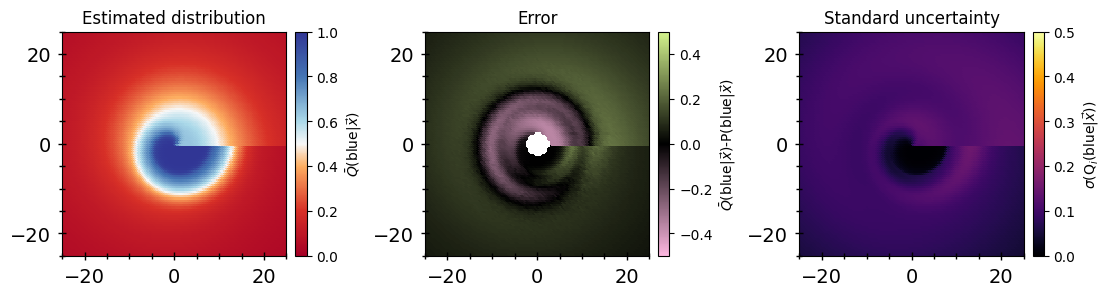

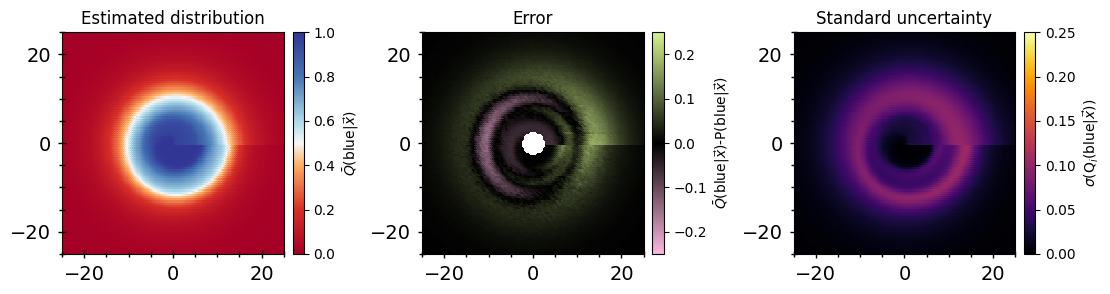

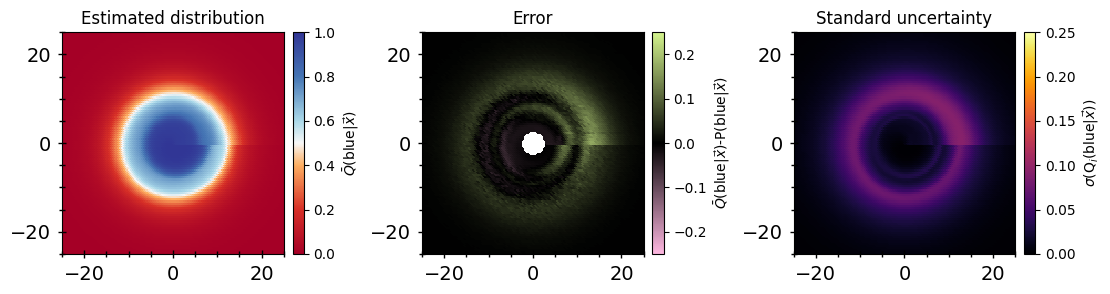

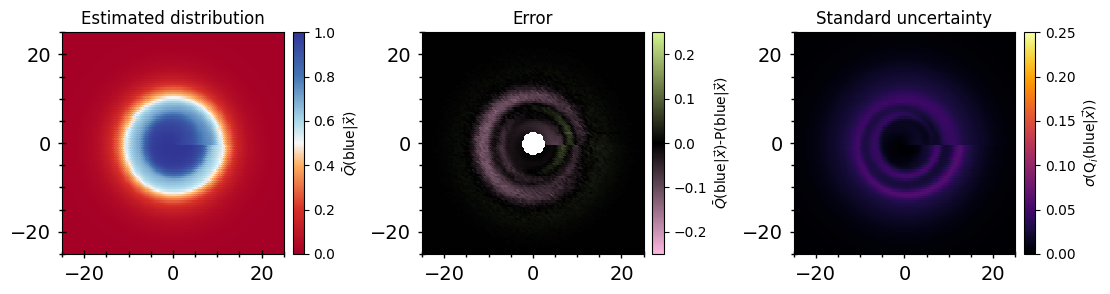

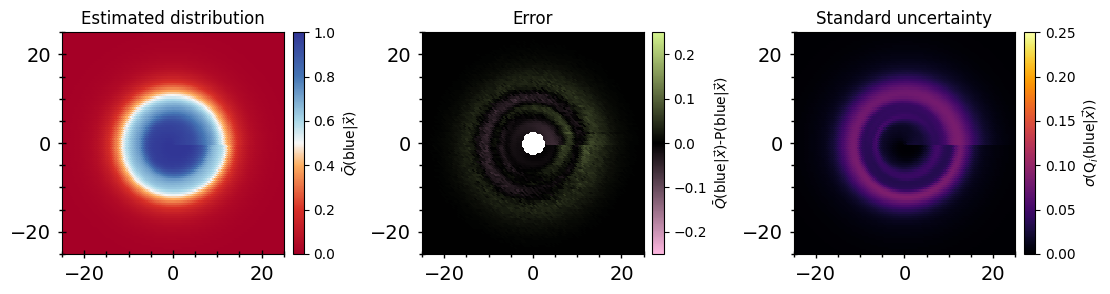

In [34]:
for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (11,3), layout="constrained")
    axs[0] = plot_results(grid_ensembles[i], "Confidence_avg", axs[0], "Estimated distribution", grid=True)
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=red_blue_cmap()), fraction=0.050, pad=0.04, label=r"$\bar{Q}$(blue|$\vec{x}$)", ax=axs[0])

    axs[1] = plot_diff(grid_ensembles[i], truth_data, "Confidence_avg", "P_blue_given_x", axs[1], r"Error", max_val = max_err_val[i])
    hue_norm = mpl.colors.Normalize(vmin=-max_err_val[i], vmax=max_err_val[i], clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=pink_black_green_cmap()), 
                 fraction=0.050, pad=0.04, label=r"$\bar{Q}$(blue|$\vec{x}$)-P(blue|$\vec{x}$)", ax=axs[1])

    axs[2] = plot_std(grid_ensembles[i], "Confidence_std", axs[2], "Standard uncertainty", grid=True, max_val = max_err_val[i])
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=max_err_val[i], clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap="inferno"), fraction=0.050, pad=0.04, label=r"$\sigma$(Q$_i$(blue|$\vec{x}$))", ax=axs[2])

    #fig.suptitle(f"Number of training datapoints: {n_data[i]}", fontsize=14)
    #fig.savefig(f"../fig/DNN_ensemble_ntrain_{n_data[i]}.pdf", format="pdf", bbox_inches='tight', dpi=350)

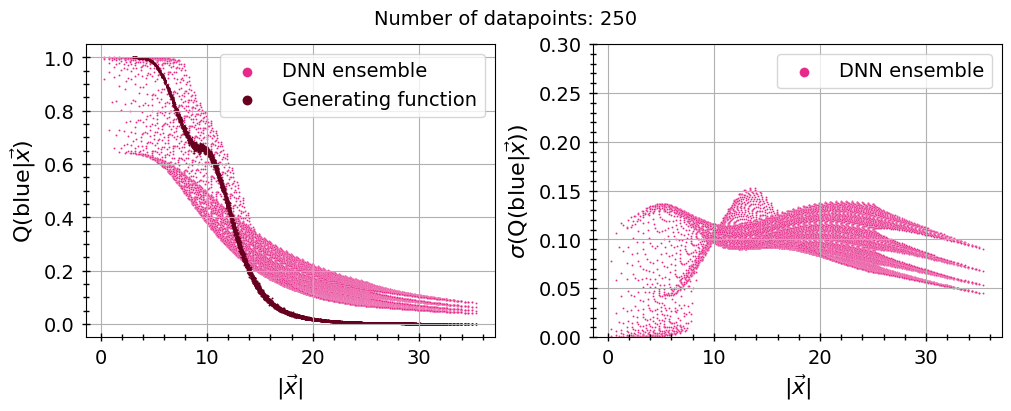

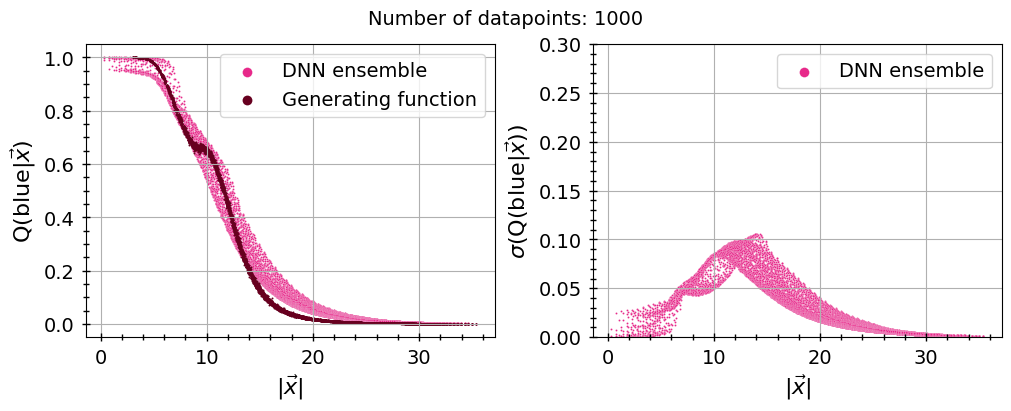

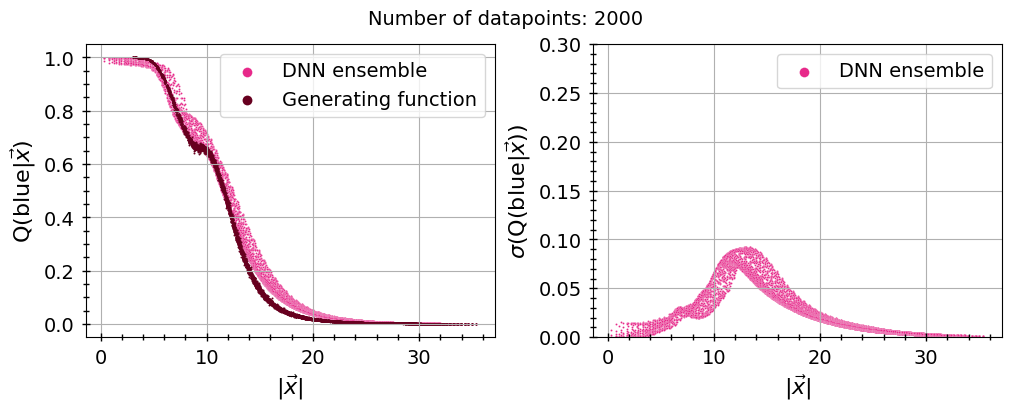

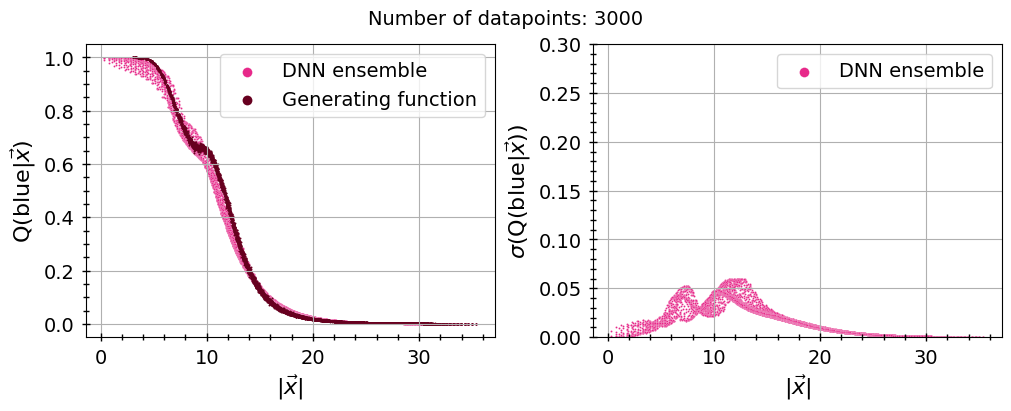

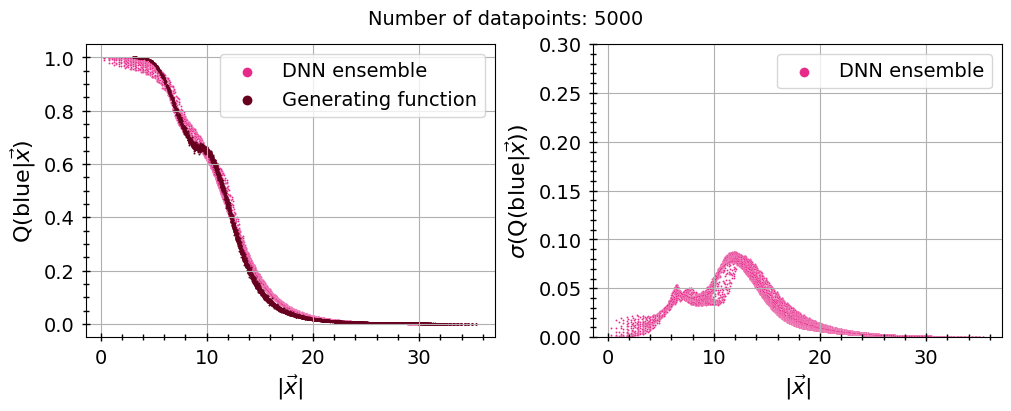

In [35]:

for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
    sn.scatterplot(grid_ensembles[i], x="r_x", y="Confidence_avg", s=2, ax = axs[0], label="DNN ensemble", color="#e7298a")
    #sn.lineplot(truth_data, x="r_x", y="P_blue_given_x", linewidth=2, ax = axs[0], label="Generating function", color="#67001f")
    sn.scatterplot(truth_data, x="r_x", y="P_blue_given_x", s=2, ax = axs[0], label="Generating function", color="#67001f", linewidth=0)
    axs[0].set_ylabel(r"Q(blue|$\vec{x}$)", fontsize=16)

    sn.scatterplot(grid_ensembles[i], x="r_x", y="Confidence_std", s=2, ax = axs[1], label="DNN ensemble", color="#e7298a")
    axs[1].set_ylabel(r"$\sigma$(Q(blue|$\vec{x}$))", fontsize=16)
    axs[1].set_ylim(0, 0.3)

    for ax in axs:
        ax.legend(markerscale=5, fontsize=14)
        ax.set_xlabel(r"$|\vec{x}|$", fontsize=16)
        ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
        ax.tick_params(which="major", length=6)
        ax.minorticks_on()
        ax.grid()
    fig.suptitle(f"Number of datapoints: {n_data[i]}", fontsize=14)

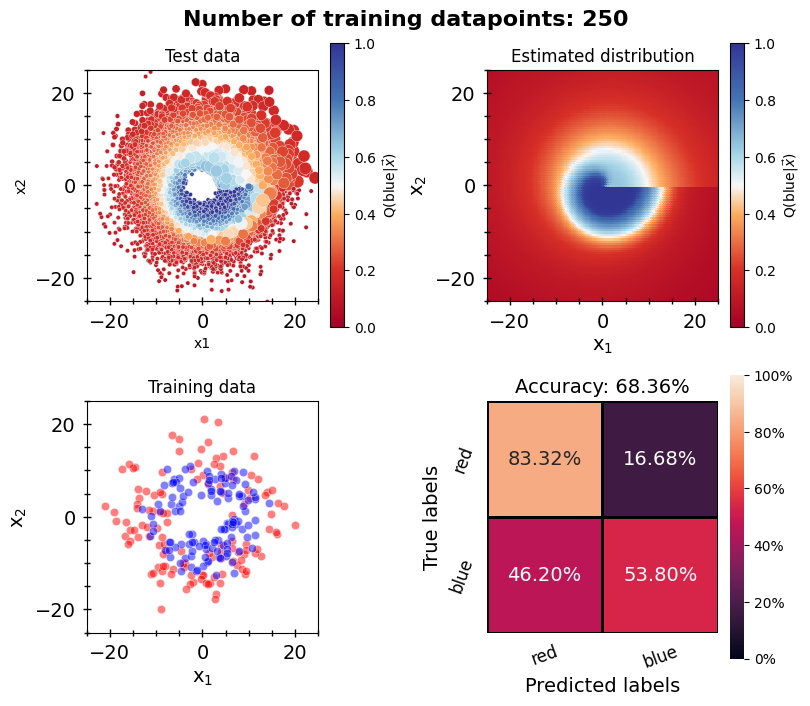

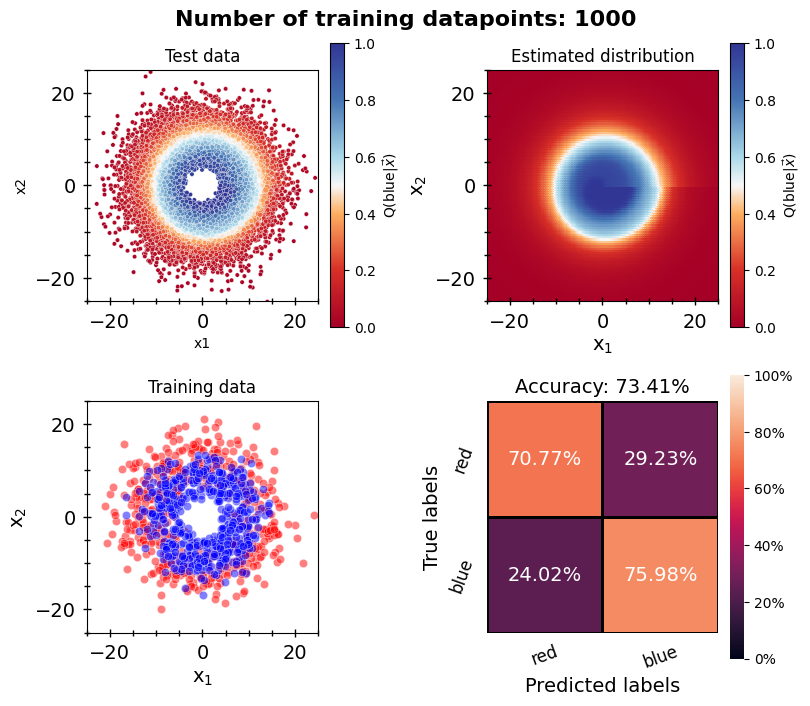

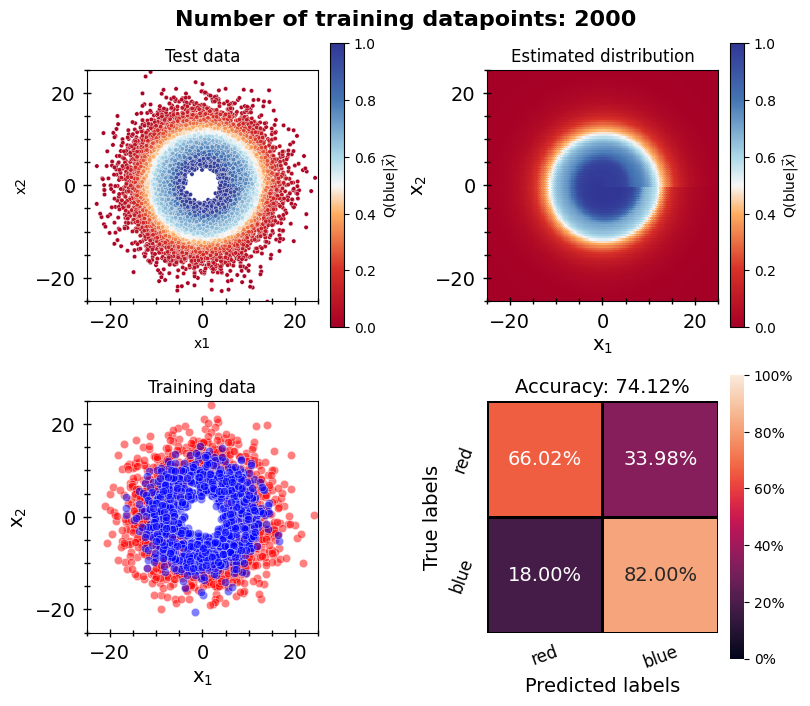

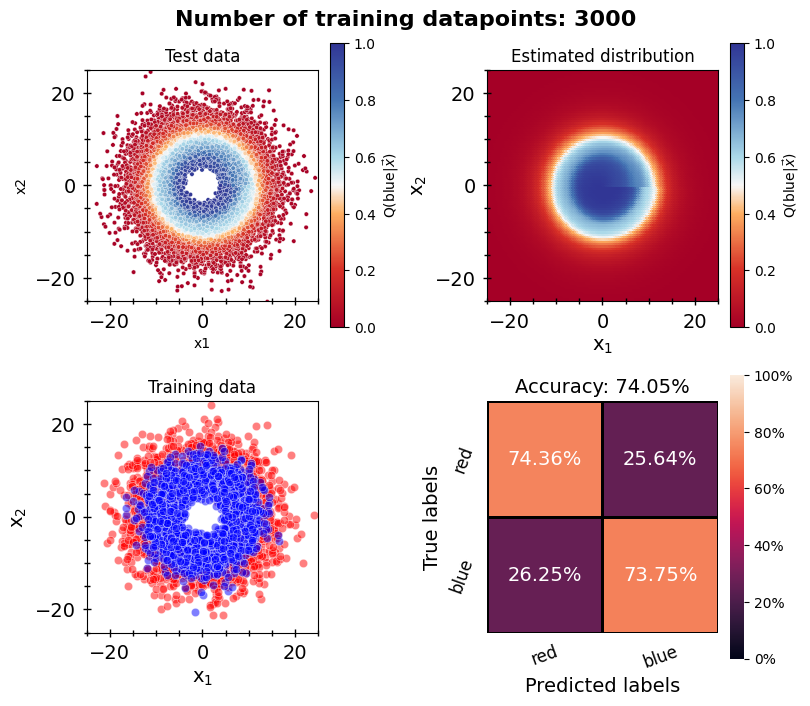

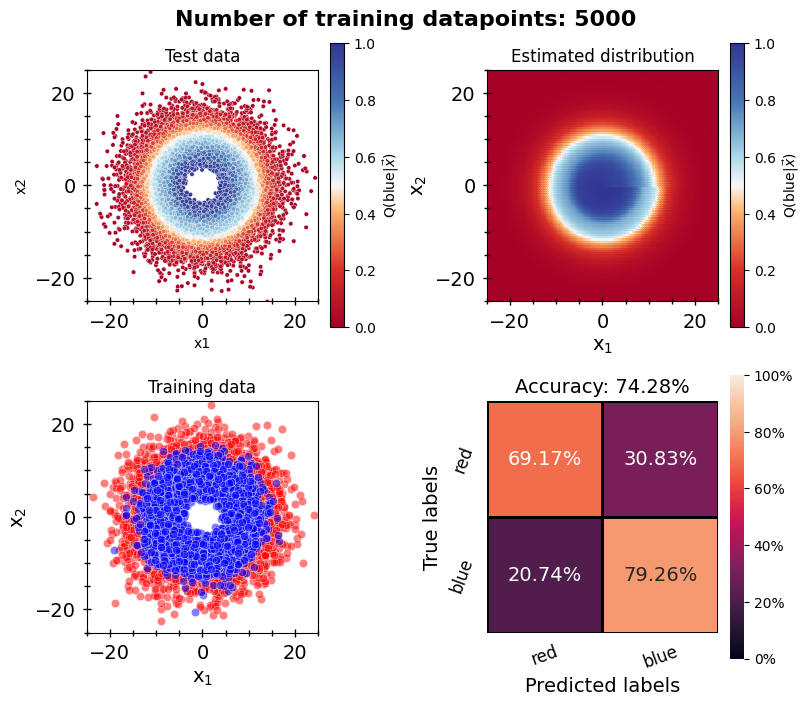

In [36]:
for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 7), layout="constrained")
    
    axs[0][0] = plot_results(test_data_ensembles[i], "Confidence_avg", axs[0][0], "Test data", "Confidence_std")
    axs[0][1] = plot_grid(grid_ensembles[i], "Confidence_avg", axs[0][1], "Estimated distribution")
    axs[1][1] = plot_conf_matrix(test_data_ensembles[i], "class", "Prediction_ensemble", ["red", "blue"], axs[1][1])
    axs[1][0] = plot_data(train_data[0:n_data[i]], axs[1][0], "Training data")

    cmap = red_blue_cmap()
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][0])
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][1])

    fig.suptitle(f"Number of training datapoints: {n_data[i]}", size=16, fontweight="bold")


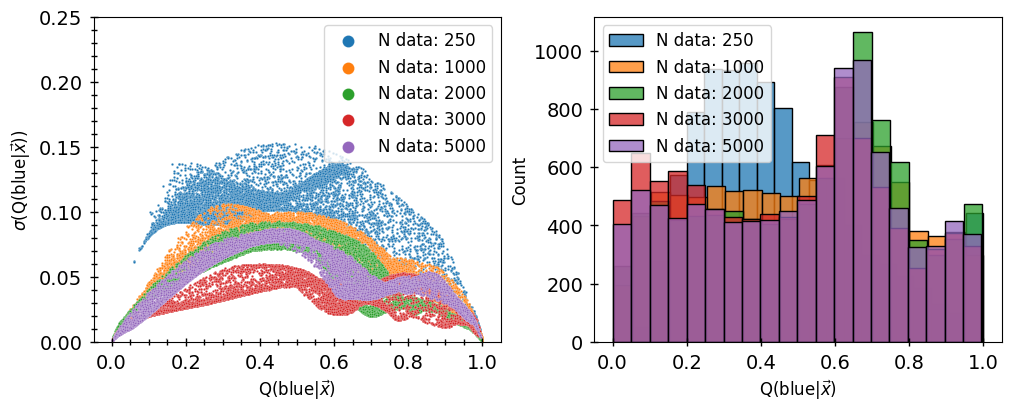

In [37]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
for i in range(len(n_data)):
    sn.scatterplot(test_data_ensembles[i], x="Confidence_avg", y="Confidence_std", s=3, label=f"N data: {n_data[i]}", ax = axs[0])
    axs[0].legend(markerscale=5, fontsize=12)
    axs[0].set_ylabel(r"$\sigma$(Q(blue|$\vec{x}$))", fontsize=12)
    axs[0].set_xlabel(r"Q(blue|$\vec{x}$)", fontsize=12)
    axs[0].set_ylim(0, 0.25)
    sn.histplot(test_data_ensembles[i], x="Confidence_avg", label=f"N data: {n_data[i]}", ax = axs[1], bins=20, edgecolor="black", linewidth=1)
    axs[1].legend(markerscale=5, fontsize=12)
    axs[1].set_ylabel("Count", fontsize=12)
    axs[1].set_xlabel(r"Q(blue|$\vec{x}$)", fontsize=12)
    for ax in axs:
        ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
        ax.tick_params(which="major", length=6)
    axs[0].minorticks_on()
    #fig.suptitle(f"Number of training datapoints: {n_data[i]}", size=16, fontweight="bold")

In [38]:
scores = calculate_metrics(test_data_ensembles, grid_ensembles, n_data, truth_data, truth_test_data, 
                           "Prediction_ensemble", "Confidence_avg", "Confidence_std")
scores.to_csv(f"predictions/{trainfile}/NNEscores.csv")
print(scores)

   N data     ACC    ROCAUC   WD test   WD grid    Avg UE    Std UE  \
0     250  0.6836  0.795251  0.099452  0.101392  0.099362  0.026741   
1    1000  0.7341  0.817064  0.031777  0.029007  0.062440  0.023176   
2    2000  0.7412  0.819715  0.027740  0.028647  0.048614  0.022955   
3    3000  0.7405  0.820728  0.032709  0.009118  0.032339  0.011902   
4    5000  0.7428  0.821213  0.017386  0.016268  0.049256  0.020824   

   Mean KL-div test  Mean KL-div grid   LogLoss       ECE       MCE     RMSCE  
0          0.037243          0.066040  0.580435  0.104009  0.167038  0.119139  
1          0.016036          0.008223  0.519597  0.031984  0.063611  0.038194  
2          0.014440          0.004424  0.514059  0.023399  0.070811  0.032416  
3          0.014843          0.000971  0.514692  0.039506  0.110864  0.051654  
4          0.012817          0.001175  0.510045  0.020815  0.055191  0.026184  


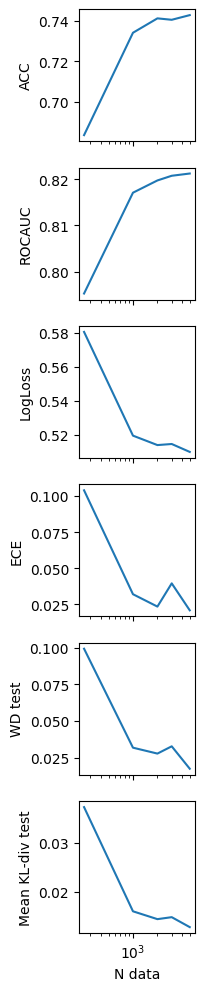

In [39]:
fig, axs = plt.subplots(nrows=6, ncols=1, figsize=(1.5, 12), sharex=True)
sn.lineplot(scores, x="N data", y="ACC", ax=axs[0])
sn.lineplot(scores, x="N data", y="ROCAUC", ax=axs[1])
sn.lineplot(scores, x="N data", y="LogLoss", ax=axs[2])
sn.lineplot(scores, x="N data", y="ECE", ax=axs[3])
sn.lineplot(scores, x="N data", y="WD test", ax=axs[4])
sn.lineplot(scores, x="N data", y="Mean KL-div test", ax=axs[5])
for ax in axs:
    ax.set_xscale("log")

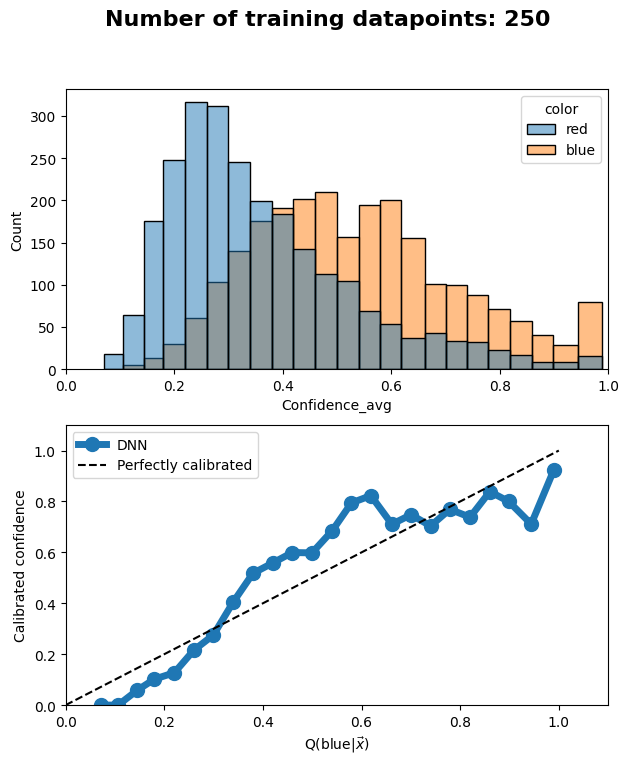

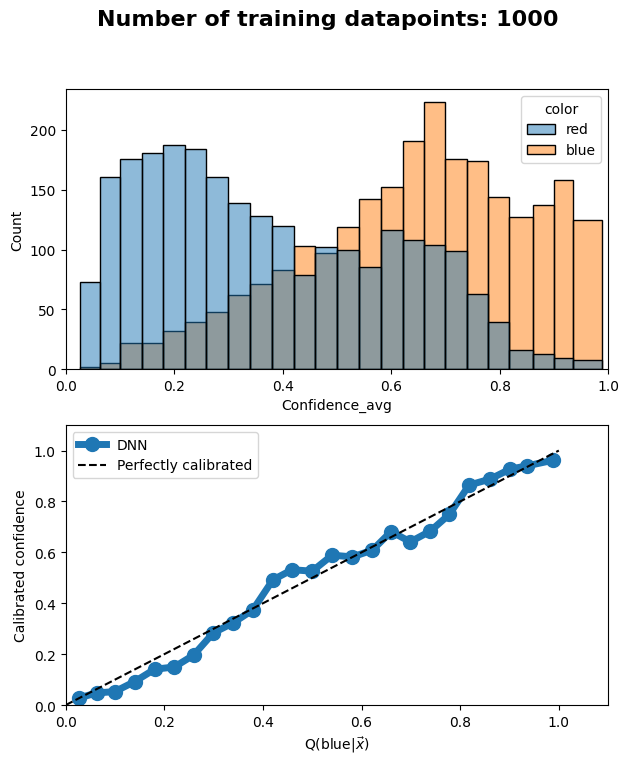

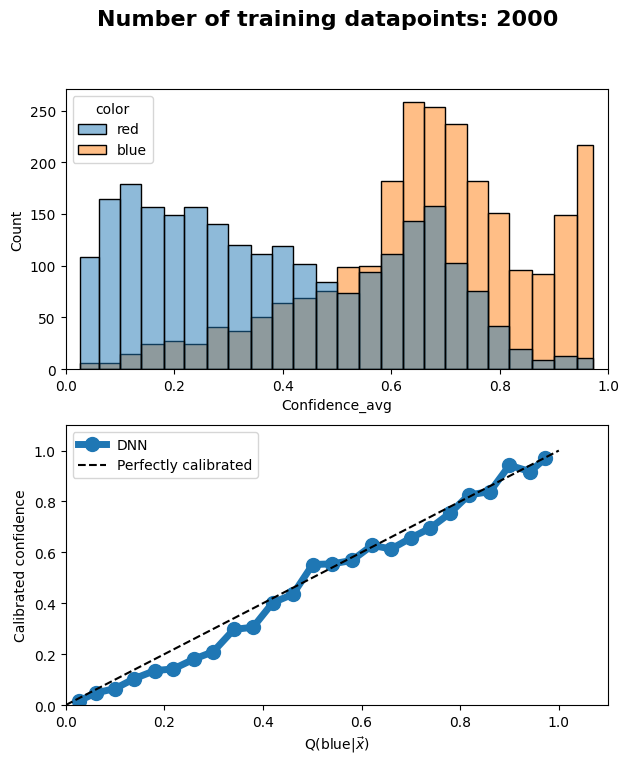

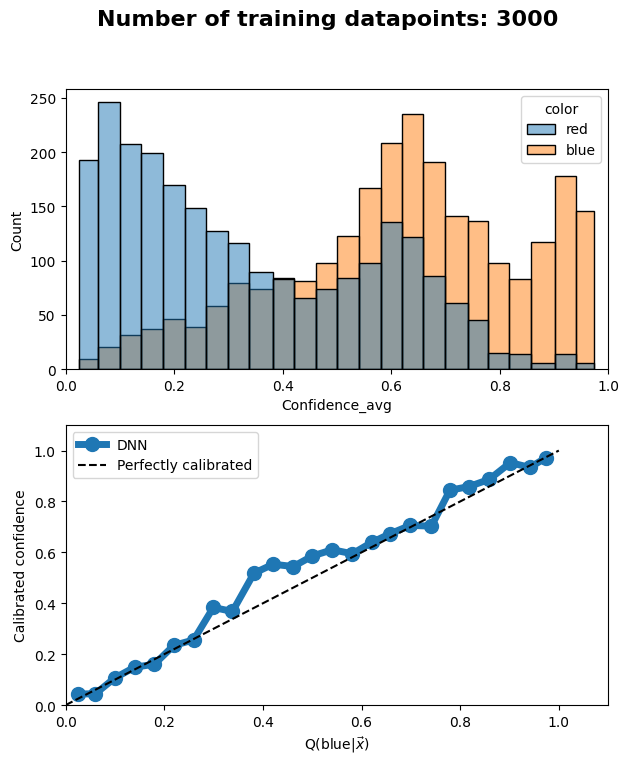

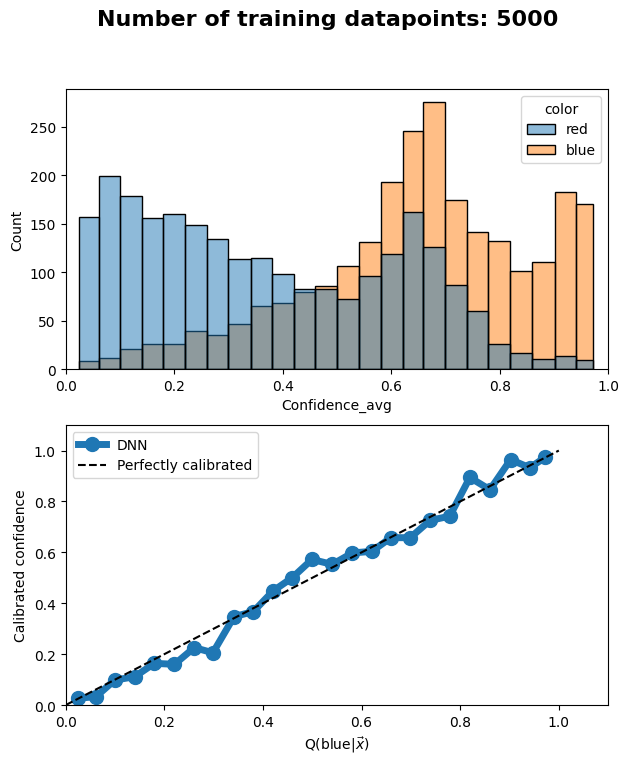

In [40]:


#Get confidence for red
for i in range(len(n_data)):
    df = val_data_ensembles[i]
    prob_cal, prob_pred = calibration_curve(df["Truth"], df["Confidence_avg"], n_bins=25, strategy="uniform")
    pred_bins=list(prob_pred)

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 8))
    sn.histplot(val_data_ensembles[i], x="Confidence_avg", hue="color", ax=ax[0], stat="count", bins=pred_bins)
    ax[0].set_xlim(0,1)
    ax[1].plot(prob_pred, prob_cal, linewidth=5, markersize=10, marker="o", label ="DNN")
    ax[1].set_xlim(0,1.1)
    ax[1].set_ylim(0,1.1)
    x = np.linspace(0, 1, 10)
    ax[1].plot(x, x, color="black", linestyle="--", label="Perfectly calibrated")
    ax[1].set_xlabel(r"Q(blue|$\vec{x}$)")
    ax[1].set_ylabel("Calibrated confidence")
    ax[1].legend()
    fig.suptitle(f"Number of training datapoints: {n_data[i]}", size=16, fontweight="bold")